In [48]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import norm

Importation of data and visualisation

In [49]:
data = pd.read_csv(r'D:\VSCodeWrokSpace\AnalyseStatTAL\monte_carlo_simulation_INFRATAL\df_currency_10y.csv', parse_dates=True)
data.set_index('date', inplace=True)

In [50]:
data

,USDSGD,USDCNY,USDEUR,USDGBP,USDCHF,USDJPY,USDGOLD
date,,,,,,,
22/04/2013 00:00,1.240,6.183,0.766,0.654,0.934,99.355,1421.30
23/04/2013 00:00,1.241,6.179,0.769,0.656,0.945,99.395,1413.40
24/04/2013 00:00,1.243,6.179,0.768,0.655,0.947,99.485,1421.10
25/04/2013 00:00,1.239,6.171,0.769,0.648,0.945,99.305,1458.30
26/04/2013 00:00,1.235,6.165,0.767,0.647,0.942,98.055,1453.00
...,...,...,...,...,...,...,...
13/04/2023 00:00,1.322,6.869,0.905,0.798,0.890,132.574,2040.63
14/04/2023 00:00,1.330,6.872,0.901,0.805,0.893,133.825,2004.18
17/04/2023 00:00,1.334,6.880,0.915,0.808,0.899,134.452,1995.50


<Axes: xlabel='date'>

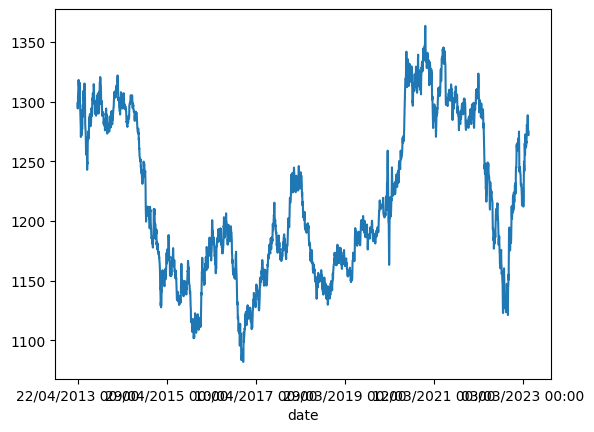

In [51]:
tal_value = (1/data['USDCHF'])*100 + (1/data['USDEUR'])*250 + (1/data['USDGBP'])*50 + (1/data['USDJPY'])*18000 + (1/data['USDCNY'])*1600 + (1/data['USDSGD']*80) + ((data['USDGOLD'])*0.2)
tal_price = tal_value
tal_price.plot()

Computation of mandatory metrics for Volatility and VaR

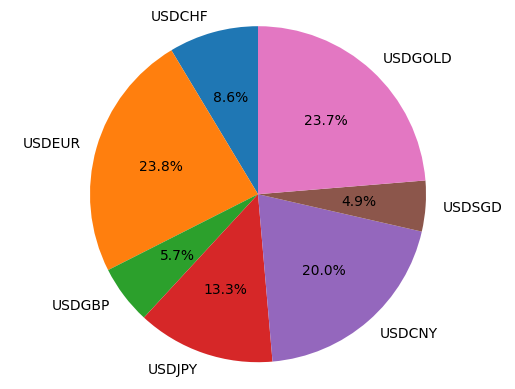

In [52]:
weights_daily = np.array([(1/data['USDCHF'])*100,(1/data['USDEUR'])*250,(1/data['USDGBP'])*50,(1/data['USDJPY'])*18000,(1/data['USDCNY'])*1600,(1/data['USDSGD'])*80,((data['USDGOLD'])*0.2)])
for i in range(len(weights_daily)):
    weights_daily[i] = weights_daily[i]/tal_price
    weights_daily[i] = weights_daily[i]/1000
weights = np.array([weights_daily[0].mean(),weights_daily[1].mean(),weights_daily[2].mean(),weights_daily[3].mean(),weights_daily[4].mean(),weights_daily[5].mean(),weights_daily[6].mean()])

labels = ['USDCHF','USDEUR','USDGBP','USDJPY','USDCNY','USDSGD','USDGOLD']
sizes = weights    
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)    
ax1.axis('equal')
plt.show()

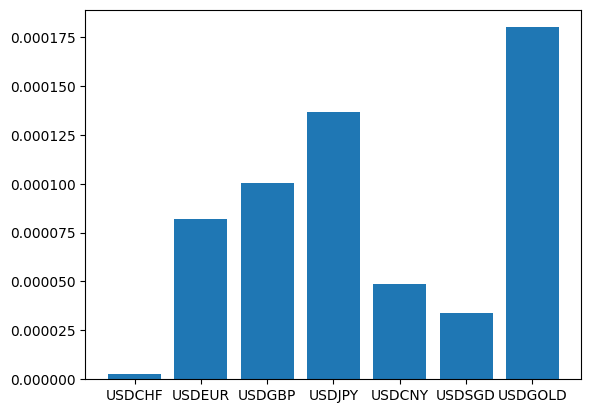

In [53]:
returns_mean = np.array([data['USDCHF'].pct_change().mean(),data['USDEUR'].pct_change().mean(),data['USDGBP'].pct_change().mean(),data['USDJPY'].pct_change().mean(),data['USDCNY'].pct_change().mean(),data['USDSGD'].pct_change().mean(),data['USDGOLD'].pct_change().mean()])

labels = ['USDCHF','USDEUR','USDGBP','USDJPY','USDCNY','USDSGD','USDGOLD']
sizes = returns_mean
fig1, ax1 = plt.subplots()
ax1.bar(height=sizes, x=labels)    
plt.show()

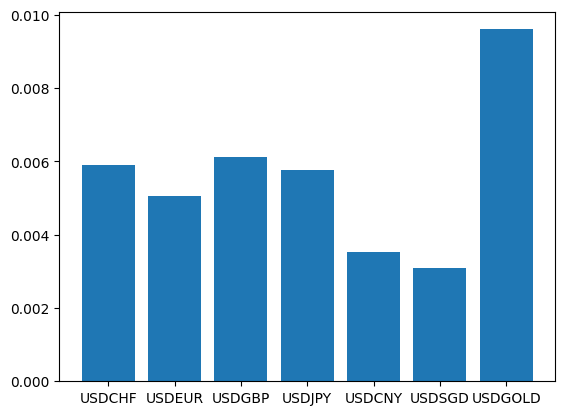

In [54]:
returns_std = np.array([data['USDCHF'].pct_change().std(),data['USDEUR'].pct_change().std(),data['USDGBP'].pct_change().std(),data['USDJPY'].pct_change().std(),data['USDCNY'].pct_change().std(),data['USDSGD'].pct_change().std(),data['USDGOLD'].pct_change().std()])

labels = ['USDCHF','USDEUR','USDGBP','USDJPY','USDCNY','USDSGD','USDGOLD']
sizes = returns_std    
fig1, ax1 = plt.subplots()
ax1.bar(height=sizes, x=labels)    
plt.show()

Text(0.5, 1.0, 'Correlation Matrix')

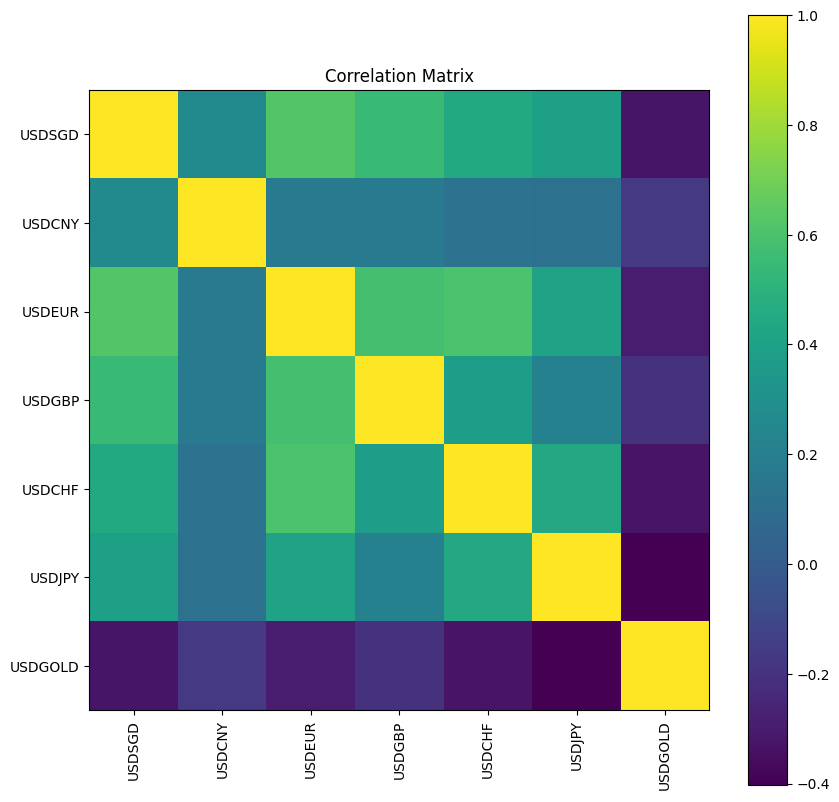

In [55]:
corr = data.pct_change().corr()
corr

plt.figure(figsize=(10, 10))
plt.imshow(corr, interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.title("Correlation Matrix")

Monte Carlo simulation with multivariate normal

In [56]:
# Paramètres de la simulation
num_simulations = 10000
num_days = 252
confidence_level = 0.99

# Paramètres du portefeuille
weights  # Poids des actifs dans le portefeuille
returns_mean  # Rendements moyens quotidiens des actifs
returns_std  # Écarts-types des rendements quotidiens des actifs
correlation_matrix = corr # Matrice de corrélation des rendements des actifs

# Génère une matrice de covariances à partir des écarts-types et de la matrice de corrélation
cov_matrix = np.diag(returns_std) @ correlation_matrix @ np.diag(returns_std)

# Simule les rendements
returns_simulated = np.random.multivariate_normal(returns_mean, cov_matrix, size=(num_simulations, num_days))

# Calcule les rendements du portefeuille pour chaque simulation
portfolio_returns_simulated = returns_simulated @ weights

# Calcule la perte en pourcentage pour chaque simulation
losses = -portfolio_returns_simulated


Historical Volatility

In [57]:
# Et les poids des actifs dans le portefeuille
weights_daily  # Poids des actifs dans le portefeuille

# Nous formons un dataframe avec les rendements des deux actifs
returns = data.pct_change()
returns = returns.T

# Nous calculons les rendements du portefeuille en multipliant les rendements de chaque actif par leurs poids 
# et en sommant le tout
returns_portfolio = (weights_daily * returns).sum(axis=1)



Results, values and calculation

In [58]:
# Calculate the VaR
VaR = np.percentile(losses, 100*(1-confidence_level))
print('VaR at', 100*confidence_level, '% confidence level:', VaR)

# Calculate the ES
ES = losses[losses > VaR].mean()
print('Expected Shortfall:', ES)

# Calcule la volatilité théorique et théorique annualisé du portefeuille
portfolio_volatility_theoretical = np.sqrt(weights @ cov_matrix @ weights.T)
portfolio_volatility_theoretical_annualized = portfolio_volatility_theoretical*np.sqrt(252)

# Nous calculons la volatilité historique annualisé et non annualisé du portefeuille en calculant l'écart-type des rendements du portefeuille
historical_portfolio_volatility = returns_portfolio.std()
historical_annualized_portfolio_volatility = returns_portfolio.std()*np.sqrt(252)

# Nous calculons la volatilité Simulé annualisé et non annualisé du portefeuille en calculant l'écart-type des rendements simulé du portefeuille
simulated_portfolio_volatility = portfolio_returns_simulated.std()
simulated_annualized_portfolio_volatility = simulated_portfolio_volatility*np.sqrt(252)


print('Volatilité theorique annualisée du portefeuille: ', portfolio_volatility_theoretical_annualized)
print('Volatilité theorique du portefeuille: ', portfolio_volatility_theoretical)
print('Volatilité historique annualisée du portefeuille :', historical_annualized_portfolio_volatility)
print('Volatilité historique du portefeuille :', historical_portfolio_volatility)
print('Volatilité simulé annualisée du portefeuille: ',simulated_annualized_portfolio_volatility)
print('Volatilité simulé du portefeuille: ',simulated_portfolio_volatility)

print('Difference entre la volatilité théorique annualisé et volatilité historique annualisé :', historical_annualized_portfolio_volatility - portfolio_volatility_theoretical_annualized)
print('Ecart relatif entre la valeur théorique annualisé et valeur historique annualisé :', ((historical_annualized_portfolio_volatility - portfolio_volatility_theoretical_annualized)/portfolio_volatility_theoretical_annualized)*100, '%')
print('Ecart relatif entre la valeur théorique annualisé et valeur simulé annualisé :', ((simulated_annualized_portfolio_volatility - portfolio_volatility_theoretical_annualized)/portfolio_volatility_theoretical_annualized)*100, '%')

VaR at 99.0 % confidence level: -6.352251587275068e-06
Expected Shortfall: -2.3659418541998335e-08
Volatilité theorique annualisée du portefeuille:  4.2666401093793135e-05
Volatilité theorique du portefeuille:  2.6877306341026397e-06
Volatilité historique annualisée du portefeuille : 0.0007672045156905847
Volatilité historique du portefeuille : 4.8329341743881875e-05
Volatilité simulé annualisée du portefeuille:  4.266484272183284e-05
Volatilité simulé du portefeuille:  2.6876324658965186e-06
Difference entre la volatilité théorique annualisé et volatilité historique annualisé : 0.0007245381145967915
Ecart relatif entre la valeur théorique annualisé et valeur historique annualisé : 1698.1467759702684 %
Ecart relatif entre la valeur théorique annualisé et valeur simulé annualisé : -0.003652457016169657 %
